In [5]:
from parcels import FieldSet, ParticleSet, JITParticle, Variable
import numpy as np
import xarray as xr
from glob import glob
from datetime import timedelta as delta
import matplotlib.pyplot as plt
import h3
import cartopy

import pickle
import sys
sys.path.append('../functions')
import hexbin_functions as hexfunc

In [6]:
with open('../data/hexgrid_no_coast.pkl', 'rb') as f:
    hexagons_grid = pickle.load(f)
    
grid = hexfunc.hexGrid(hexagons_grid)

In [7]:
class EnsembleParticle(JITParticle):
    """
    Particle class definition with additional variables
    """
    # dynamic variables
    u = Variable('u', dtype=np.float32, initial=0)
    v = Variable('v', dtype=np.float32, initial=0)
    w = Variable('w', dtype=np.float32, initial=0)
    
    hexbin_id = Variable('hexbin_id', dtype=np.int16, initial=0)

In [4]:
def SampleField(particle, fieldset, time):
    """
    Sample the fieldset at the particle location and store it in the
    particle variable.
    """
    (ui, vi, wi) = fieldset.UVW.eval(time, particle.depth, particle.lat, particle.lon, 
                                     particle=particle, applyConversion=False)
    particle.u = ui
    particle.v = vi
    particle.w = wi

In [43]:
def compute_cosine_similarity(vec1, vec2):
    """Compute cosine similarity between two 2D vectors."""
    dot_product = np.dot(vec1, vec2)
    magnitude1 = np.linalg.norm(vec1)
    magnitude2 = np.linalg.norm(vec2)
    return dot_product / (magnitude1 * magnitude2)

def compute_correlation_function(x_components, y_components, max_lag):
    """
    Compute the correlation function based on lag for a set of 2D vectors.

    Parameters:
    - x_components (list): List of x-components of the 2D vectors.
    - y_components (list): List of y-components of the 2D vectors.
    - max_lag (int): Maximum lag to consider for computing the correlation function.

    Returns:
    - correlations (list): List of tuples containing the lag and the average correlation for that lag.

    The function computes the correlation function based on lag for a set of 2D vectors.
    It calculates the correlation between each pair of vectors separated by a lag value
    ranging from 1 to max_lag. The correlation is computed using the Pearson correlation
    coefficient. The average correlation for each lag is then calculated and stored in a list
    of tuples, where each tuple contains the lag and the average correlation for that lag.
    The list of tuples is returned as the output of the function.
    """
    n = len(x_components)
    correlations = []

    for lag in range(1, max_lag + 1):
        lag_correlations = []

        for i in range(n - lag):
            vec1 = (x_components[i], y_components[i])
            vec2 = (x_components[i + lag], y_components[i + lag])
            correlation = compute_cosine_similarity(vec1, vec2)
            lag_correlations.append(correlation)

        average_correlation = np.mean(lag_correlations)
        correlations.append(average_correlation)

    return correlations

In [59]:
loc1_lon = -74.0
loc1_lat = 35.5

# Find the hexagon containing the location

loc1_hex = h3.geo_to_h3(loc1_lat, loc1_lon, 3)

loc1_lat, loc1_lon = h3.h3_to_geo(loc1_hex)

lon_0 = loc1_lon
lat_0 = loc1_lat

# Define the rings where we place the particles
L_range = np.arange(0.01, 2.5, 0.01)
theta_range = np.arange(0, 2*np.pi, np.pi/40)
lonp = [lon_0]
latp = [lat_0]

max_lag = 125
R_members = np.zeros((50, max_lag))

for member in range(1, 10):
    print(f"Member {member}")

    data_path = '/storage/shared/oceanparcels/input_data/NEMO_Ensemble/'
    ufiles = sorted(glob(f"{data_path}NATL025-CJMCYC3.{member:03d}-S/1d/2010/NATL025*U.nc"))
    vfiles = [f.replace('U.nc', 'V.nc') for f in ufiles]
    wfiles = [f.replace('U.nc', 'W.nc') for f in ufiles]
    mesh_mask = f"{data_path}GRID/coordinates_NATL025_v2.nc"
    maskfile = f"{data_path}GRID/NATL025-CJMenobs01_byte_mask.nc"

    filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': ufiles},
                'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': vfiles},
                'W': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': wfiles},
                'mask': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': maskfile}}
    variables = {'U': 'vozocrtx', 'V': 'vomecrty', 'W': 'vovecrtz', 'mask': 'fmask'}
    dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
                'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
                'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
                'mask': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw'}}

    fieldset = FieldSet.from_nemo(filenames, variables, dimensions, netcdf_decodewarning=False)
        
    for r in L_range:
        theta = np.pi/2
        # for theta in theta_range:
        lonp.append(lon_0 + np.sin(theta)*r) 
        latp.append(lat_0 + np.cos(theta)*r)

    end_time = np.datetime64('2010-01-02') + np.timedelta64(1, 'h')
    times = [np.datetime64('2010-01-02')]*len(lonp)
    depp = np.ones(len(lonp))
    pset = ParticleSet(fieldset, EnsembleParticle, lon=lonp, lat=latp, depth=depp, time=times)
        
    pset.execute([SampleField], 
                dt=delta(hours=1), endtime=end_time)


    R_values = compute_correlation_function(pset.u, pset.v, max_lag)
        
    R_members[member-1, :] = np.array(R_values)
    


Member 1
100%|██████████| 3600.0/3600.0 [00:00<00:00, 35730.08it/s]
Member 2
100%|██████████| 3600.0/3600.0 [00:00<00:00, 34697.20it/s]
Member 3
100%|██████████| 3600.0/3600.0 [00:00<00:00, 34947.60it/s]
Member 4
100%|██████████| 3600.0/3600.0 [00:00<00:00, 33641.15it/s]
Member 5
100%|██████████| 3600.0/3600.0 [00:00<00:00, 33775.40it/s]
Member 6
100%|██████████| 3600.0/3600.0 [00:00<00:00, 33313.39it/s]
Member 7
100%|██████████| 3600.0/3600.0 [00:00<00:00, 32869.43it/s]
Member 8
100%|██████████| 3600.0/3600.0 [00:00<00:00, 32157.03it/s]
Member 9
100%|██████████| 3600.0/3600.0 [00:00<00:00, 31823.38it/s]


Text(0, 0.5, 'R')

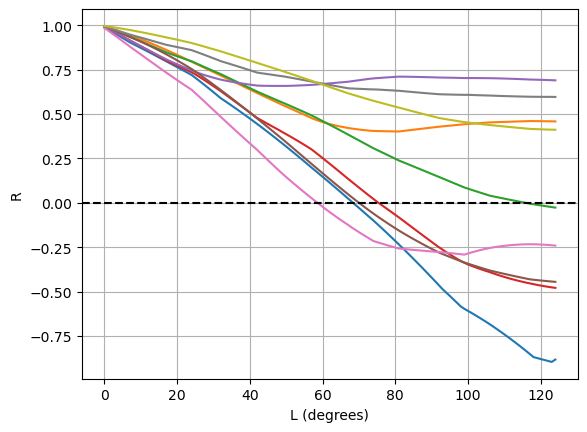

In [61]:
for member in range(1, 10):
    plt.plot(R_members[member - 1, :])
    
plt.grid()

plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('L (degrees)')
plt.ylabel('R')

In [65]:
# find where R intersects 0 for the first time
L = np.where(R_members[0, :] < 0)[0][0]
print(f"First intersection with 0: {L*0.01} degrees")

First intersection with 0: 0.6900000000000001 degrees


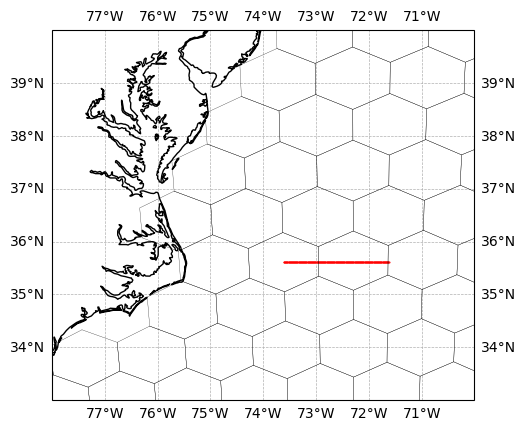

In [21]:
# Plot NA_domain on a map
depth = 0
fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent([-78, -70, 33, 40], crs=cartopy.crs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)

hexfunc.plot_hexagons(ax, hexagons_grid, colors='r', draw_edges=True, fill_polygons=False)

ax.scatter(pset.lon, pset.lat, 
           transform=cartopy.crs.PlateCarree(), s=0.2, c='r')

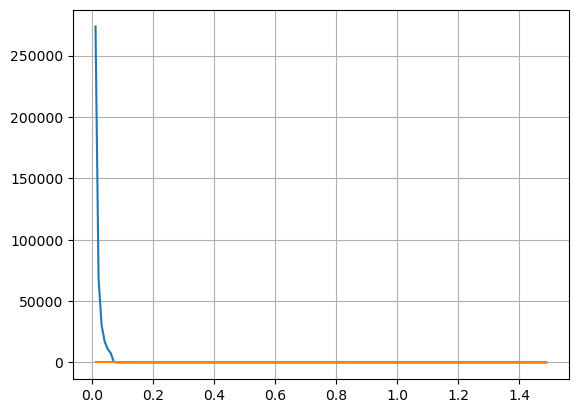

In [8]:
for member in range(1, 3):
    plt.plot(L_range, R_members[member,:])
    
plt.grid()

In [96]:
end_time = np.datetime64('2010-01-02') + np.timedelta64(1, 'h')
pset.execute([SampleField], 
             dt=delta(hours=1), endtime=end_time)
# pset.execute([SampleField], dt=delta(hours=1))

100%|██████████| 3600.0/3600.0 [00:00<00:00, 36148.96it/s]


In [97]:
pset

P[1458](lon=-73.611843, lat=35.609134, depth=1.000000, u=0.000002, v=-0.000003, w=-0.000001, hexbin_id=0.000000, time=43200.000000)
P[1459](lon=-73.611843, lat=36.409134, depth=1.000000, u=0.000001, v=-0.000003, w=-0.000002, hexbin_id=0.000000, time=43200.000000)
P[1460](lon=-73.549076, lat=36.406668, depth=1.000000, u=0.000001, v=-0.000003, w=-0.000002, hexbin_id=0.000000, time=43200.000000)
P[1461](lon=-73.486695, lat=36.399284, depth=1.000000, u=0.000001, v=-0.000004, w=-0.000002, hexbin_id=0.000000, time=43200.000000)
P[1462](lon=-73.425087, lat=36.387030, depth=1.000000, u=0.000001, v=-0.000003, w=0.000004, hexbin_id=0.000000, time=43200.000000)
P[1463](lon=-73.364629, lat=36.369979, depth=1.000000, u=0.000000, v=-0.000003, w=0.000004, hexbin_id=0.000000, time=43200.000000)
P[1464](lon=-73.305696, lat=36.348237, depth=1.000000, u=-0.000000, v=-0.000003, w=0.000004, hexbin_id=0.000000, time=43200.000000)
P[1465](lon=-73.248650, lat=36.321939, depth=1.000000, u=-0.000001, v=-0.00000

In [ ]:

# # Plot NA_domain on a map
# depth = 0
# fig = plt.figure()
# ax = plt.axes(projection=cartopy.crs.PlateCarree())
# ax.set_extent([-78, -70, 33, 40], crs=cartopy.crs.PlateCarree())
# ax.coastlines()
# ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)

# hexfunc.plot_hexagons(ax, hexagons_grid, colors='r', draw_edges=True, fill_polygons=False)

# ax.scatter(pset.lon, pset.lat, 
#            transform=cartopy.crs.PlateCarree(), s=1, c='r')

In [98]:
u0 = pset.u[0]
v0 = pset.v[0]


rho1 = np.mean(pset.u[1:]*u0 + pset.v[1:]*v0)
umean = np.mean(pset.u[1:] + pset.v[1:])**2

uvar = np.mean((pset.u[1:])**2 + (pset.v[1:])**2) 

R = rho1/(uvar)

print(R)

# # for i in range(1, len(pset)):
# #     rho1 += (pset.u[i]*u0 + pset.v[i]*v0)
# #     uvar += (pset.u[i]**2 + pset.v[i]**2)
# #     uu += (pset.u[i]+ pset.v[i])
    
# # for i in range(1, len(pset)):
# #     rho1 += (pset.u[i]*u0)
# #     uvar += (pset.u[i]**2)
# #     uu += (pset.u[i])

# rho1 /= len(pset)-2
# uvar /= len(pset)-2
# umean /= len(pset)-2

# R = rho1

# rho /= len(pset)-1
# rho    

0.14803609


1.6897246796210296e-11

In [22]:
np.variance



AttributeError: module 'numpy' has no attribute 'variance'